In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() 
import numpy as np

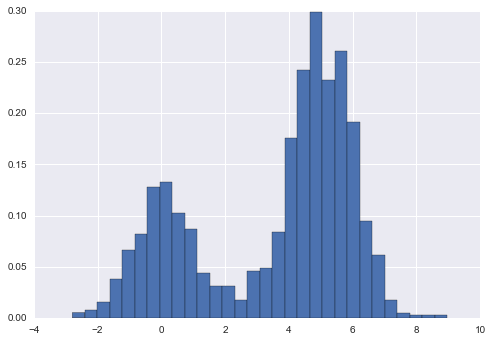

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N) 
    x[int(f * N):] += 5 
    return x
           
    
x = make_data(1000)
hist = plt.hist(x, bins=30, normed=True)

In [3]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

In [4]:
widths

array([ 0.39172292,  0.39172292,  0.39172292,  0.39172292,  0.39172292,
        0.39172292,  0.39172292,  0.39172292,  0.39172292,  0.39172292,
        0.39172292,  0.39172292,  0.39172292,  0.39172292,  0.39172292,
        0.39172292,  0.39172292,  0.39172292,  0.39172292,  0.39172292,
        0.39172292,  0.39172292,  0.39172292,  0.39172292,  0.39172292,
        0.39172292,  0.39172292,  0.39172292,  0.39172292,  0.39172292])

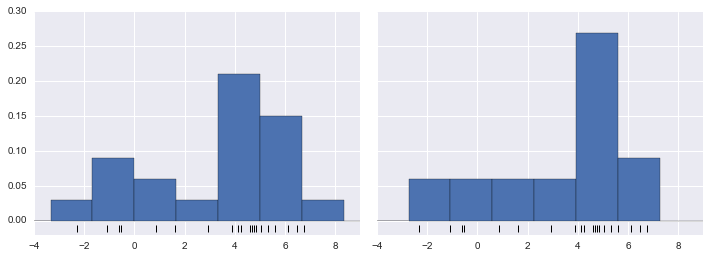

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]): 
    ax[i].hist(x, bins=bins + offset, normed=True) 
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

In [6]:
x

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  6.74481176,  4.2387931 ,  5.3190391 ,  4.75062962,
        6.46210794,  2.93985929,  4.6775828 ,  4.61594565,  6.13376944,
        3.90010873,  4.82757179,  4.12214158,  5.04221375,  5.58281521])

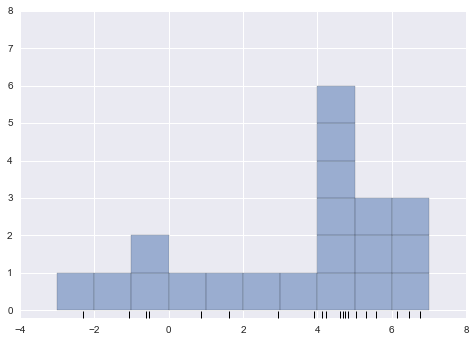

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)): 
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
        ax.set_xlim(-4, 8)
        ax.set_ylim(-0.2, 8)

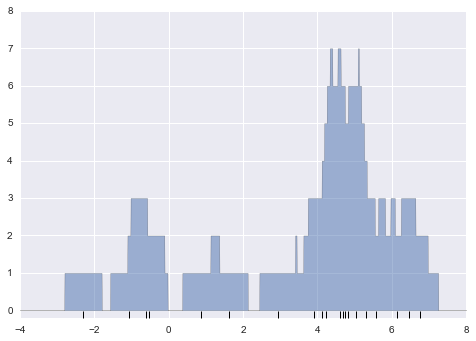

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8]);

In [9]:
x

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  6.74481176,  4.2387931 ,  5.3190391 ,  4.75062962,
        6.46210794,  2.93985929,  4.6775828 ,  4.61594565,  6.13376944,
        3.90010873,  4.82757179,  4.12214158,  5.04221375,  5.58281521])

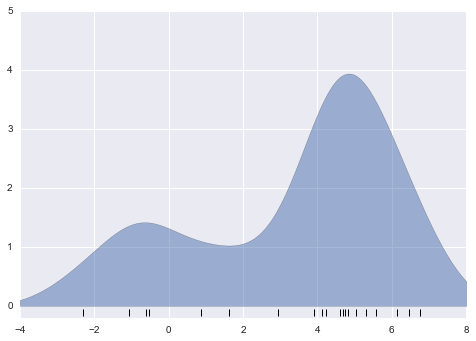

In [10]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 5]);

(-0.02, 0.22)

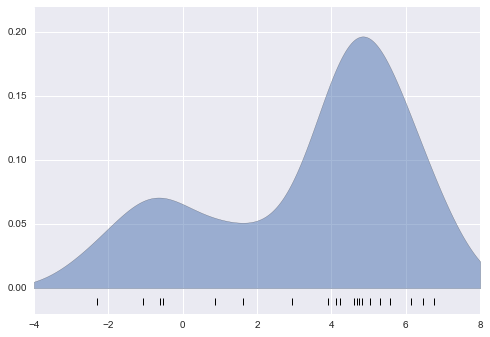

In [11]:
from sklearn.neighbors import KernelDensity
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

In [14]:
from sklearn.grid_search import GridSearchCV 
from sklearn.model_selection import LeaveOneOut  ## deprecated
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut().get_n_splits(x[:, None]))
grid.fit(x[:, None]);
grid.best_params_

{'bandwidth': 1.1233240329780276}

In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin 
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'): 
        self.bandwidth = bandwidth
        self.kernel = kernel
    
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_] 
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi) for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] * 1.0 / X.shape[0]) for Xi in training_sets]
        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T 
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True) 

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

{'bandwidth': 7.0548023107186433}
('accuracy =', 0.9666110183639399)


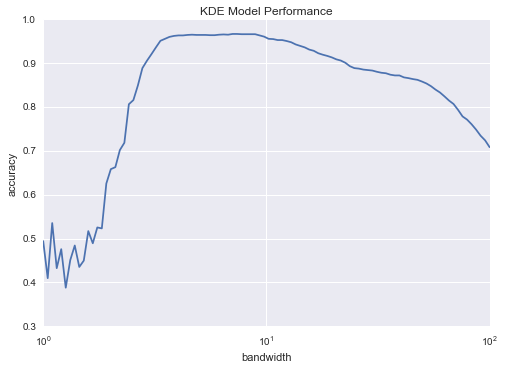

In [23]:
from sklearn.datasets import load_digits 
from sklearn.grid_search import GridSearchCV
digits = load_digits()
bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)
scores = [val.mean_validation_score for val in grid.grid_scores_]
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_) 
print('accuracy =', grid.best_score_)

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score 
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.81860038035501381